# Feature Summary
### Stock Price
`Price`: Date of the stock data (needs cleaning as the first two rows are headers).    
`Adj Close`: Adjusted closing price, accounting for events like dividends and splits.    
`Close`: Closing price of the stock at the end of the trading day.  
`High`: Highest price of the stock during the trading day.  
`Low`: Lowest price of the stock during the trading day.  
`Open`: Opening price of the stock at the start of the trading day.  
`Volume`: Number of shares traded during the day.   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


google = pd.read_csv('googl_data_2020_2025.csv')

# EDA

## Google Stock

In [2]:
google.head(10)

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-02 00:00:00+00:00,68.18682098,68.43399811,68.43399811,67.32450104,67.42050171,27278000
3,2020-01-03 00:00:00+00:00,67.83010101,68.0759964,68.6875,67.36599731,67.40000153,23408000
4,2020-01-06 00:00:00+00:00,69.63805389,69.89050293,69.91600037,67.55000305,67.58149719,46768000
5,2020-01-07 00:00:00+00:00,69.50354767,69.75550079,70.17500305,69.57800293,70.02300262,34330000
6,2020-01-08 00:00:00+00:00,69.99825287,70.2519989,70.59249878,69.63150024,69.74099731,35314000
7,2020-01-09 00:00:00+00:00,70.73309326,70.98950195,71.43399811,70.51049805,71.09649658,33200000
8,2020-01-10 00:00:00+00:00,71.18992615,71.44799805,71.74700165,70.98000336,71.47350311,26258000
9,2020-01-13 00:00:00+00:00,71.74143219,72.00150299,72.0739975,71.26850128,71.76249695,30730000


In [3]:
# Drop the first 2 rows
google = google.drop(index=[0,1]).reset_index(drop=True)  # prevents the old index from being added as a new column

# Rename column "Price" to "Date"
google.rename(columns={'Price': 'Date'}, inplace=True)

In [4]:
# Print info
print(google.info())

# check for missing values
print('\nCheck for missing values:')
print(google.isnull().sum())

# check for duplicate values
print('\nCheck for duplicate value:')
print(google.duplicated().value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       1258 non-null   object
 1   Adj Close  1258 non-null   object
 2   Close      1258 non-null   object
 3   High       1258 non-null   object
 4   Low        1258 non-null   object
 5   Open       1258 non-null   object
 6   Volume     1258 non-null   object
dtypes: object(7)
memory usage: 68.9+ KB
None

Check for missing values:
Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

Check for duplicate value:
False    1258
Name: count, dtype: int64


In [5]:
# Convert "Date" column to datetime, forcing errors to NaN, then format to 'yyyy-mm-dd'
google['Date'] = pd.to_datetime(google['Date'], errors='coerce').dt.date

# Convert back to datetime
google['Date'] = pd.to_datetime(google['Date'])

# Convert columns to numeric, forcing errors to NaN
google[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']] = google[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].apply(pd.to_numeric, errors='coerce')

# Check dataset again
google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1258 non-null   datetime64[ns]
 1   Adj Close  1258 non-null   float64       
 2   Close      1258 non-null   float64       
 3   High       1258 non-null   float64       
 4   Low        1258 non-null   float64       
 5   Open       1258 non-null   float64       
 6   Volume     1258 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.9 KB


In [6]:
google.describe()

,Date,Adj Close,Close,High,Low,Open,Volume
count,1258,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,2022-07-01 15:39:46.645468928,118.684965,119.075610,120.378055,117.722657,119.004592,3.308795e+07
min,2020-01-02 00:00:00,52.516125,52.706501,53.345501,50.443501,52.818501,9.312000e+06
25%,2021-04-02 00:00:00,93.608171,93.947502,95.272123,92.305002,93.832497,2.343938e+07
50%,2022-06-30 12:00:00,119.267639,119.699997,121.044502,118.626247,119.712502,2.943300e+07
75%,2023-10-01 06:00:00,140.598320,141.107998,142.101002,139.796120,140.996876,3.773515e+07
max,2024-12-31 00:00:00,196.660004,196.660004,201.419998,194.979996,197.250000,1.232000e+08
std,NaN,32.403071,32.453265,32.688266,32.248276,32.481362,1.461758e+07


C:\Users\HanDong\AppData\Local\Temp\ipykernel_3272\1875884726.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=google, x='Year', palette='viridis')


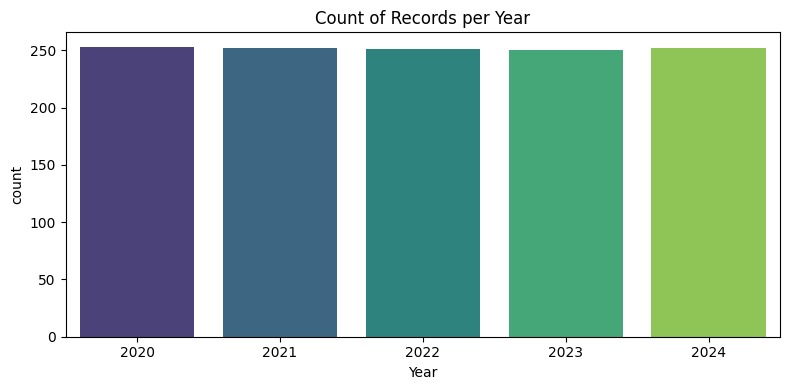

In [7]:
# Create more features to analyse
google['Year'] = google['Date'].dt.year
google['Month'] = google['Date'].dt.month
google['Day'] = google['Date'].dt.day

# Count plot (pie chart style) for the 'Year' column to inspect distribution over time
plt.figure(figsize=(8, 4))
sns.countplot(data=google, x='Year', palette='viridis')
plt.title('Count of Records per Year')
plt.tight_layout()
plt.show()

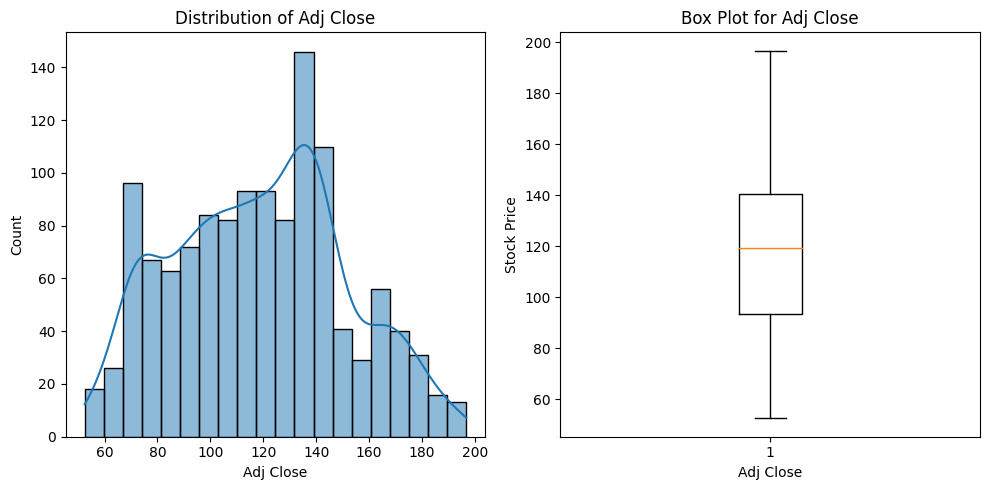

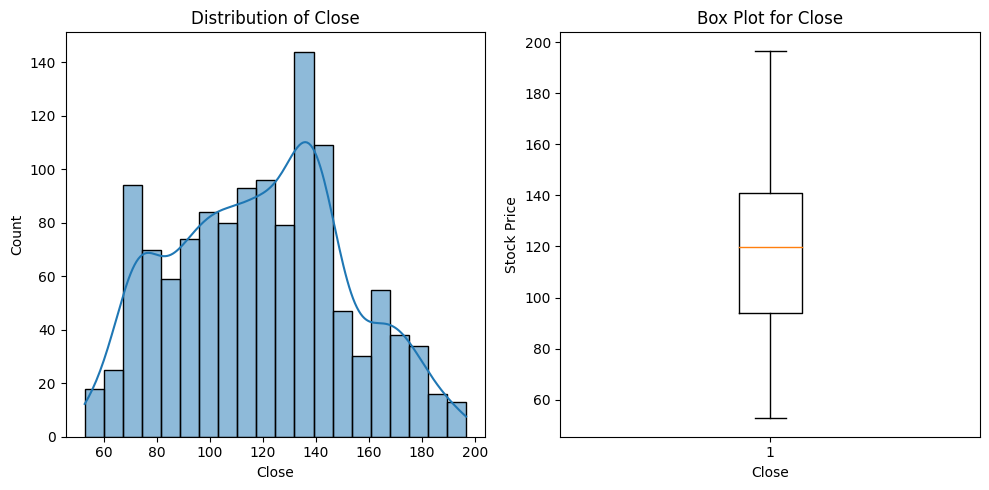

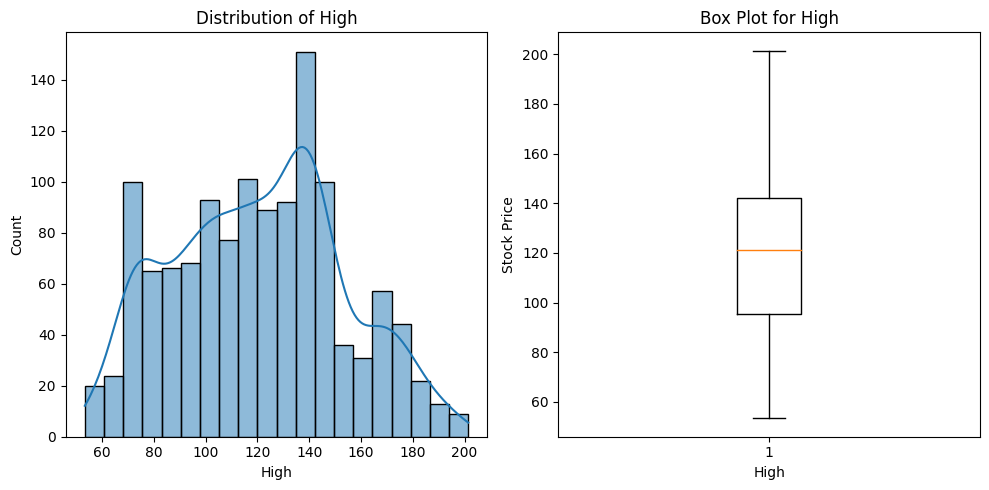

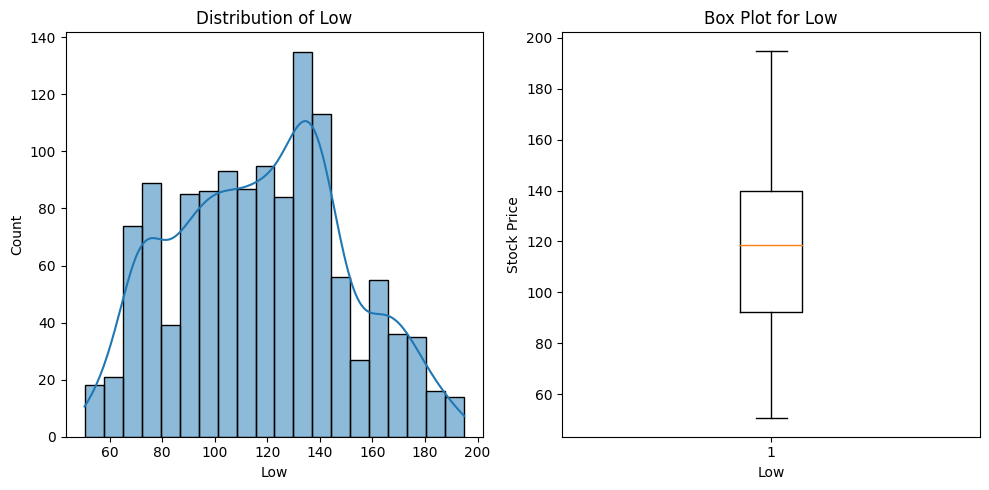

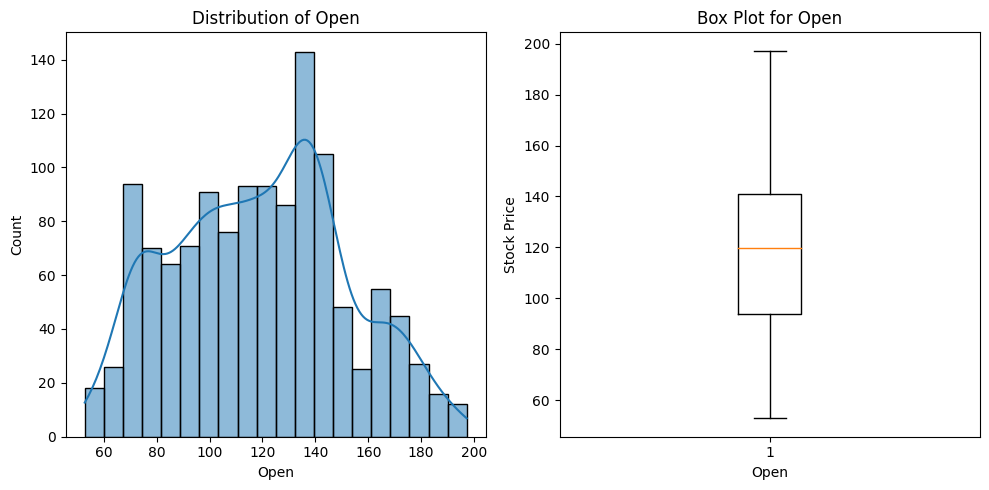

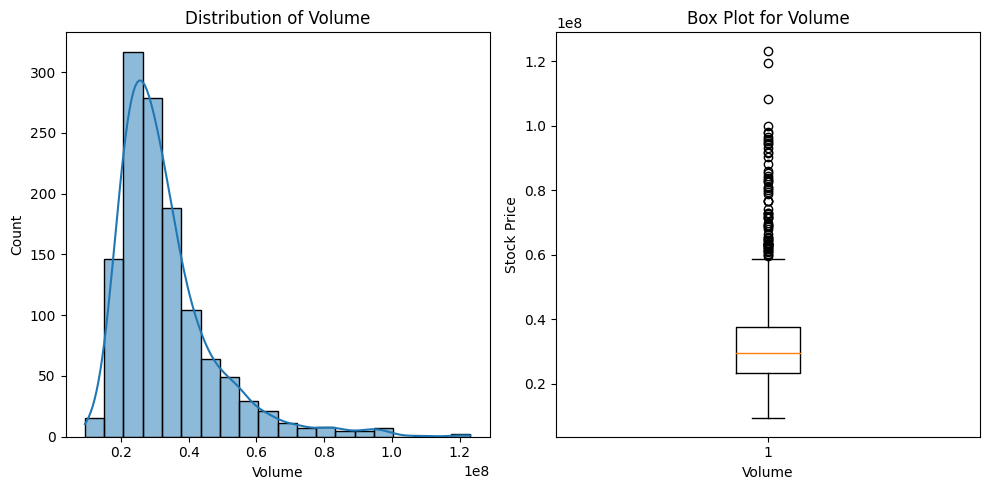

In [8]:
# Distribution of features
numeric_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
for col in numeric_cols:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.histplot(data=google, x=col, kde=True, bins=20)
    plt.title(f"Distribution of {col}")

    plt.subplot(1,2,2)
    plt.boxplot(x=google[col])
    plt.title(f"Box Plot for {col}")
    plt.ylabel("Stock Price")
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()

### Outlier Analysis: Trading
We analyzed the trading volume (Volume) column in the dataset using the IQR (Interquartile Range) method and obtained the following results:

Total data points: 1258  
Outliers detected: 70 (5.56%)    

Minimum and maximum values of outliers:   
Minimum: 9,312,000   
Maximum: 123,200,000 (Clearly an extreme outlier!)

**Should We Remove Outliers?**    
Outliers Are Important in Financial Data: Significant increases in trading volume are usually caused by major market movements, investor sentiment, or important news (e.g., earnings reports, major deals).     
Low Percentage of Outliers (5.56%): Since outliers only make up 5.56% of the dataset, removing them could make it harder to analyze major market movements.     
A More Logical Approach: Instead of removing all outliers, we could only eliminate extreme values (e.g., trading volumes above 100 million) for a better analysis.    

In [9]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = google['Volume'].quantile(0.25)
Q3 = google['Volume'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
upper_bound = Q3 + 1.5 * IQR
extreme_outliers = google[google['Volume'] > (upper_bound + 1.5 * IQR)]

# Count the number of outliers
count_extreme_outliers = extreme_outliers.shape[0]

print(f"Number of extreme outliers: {count_extreme_outliers}")

Number of extreme outliers: 25


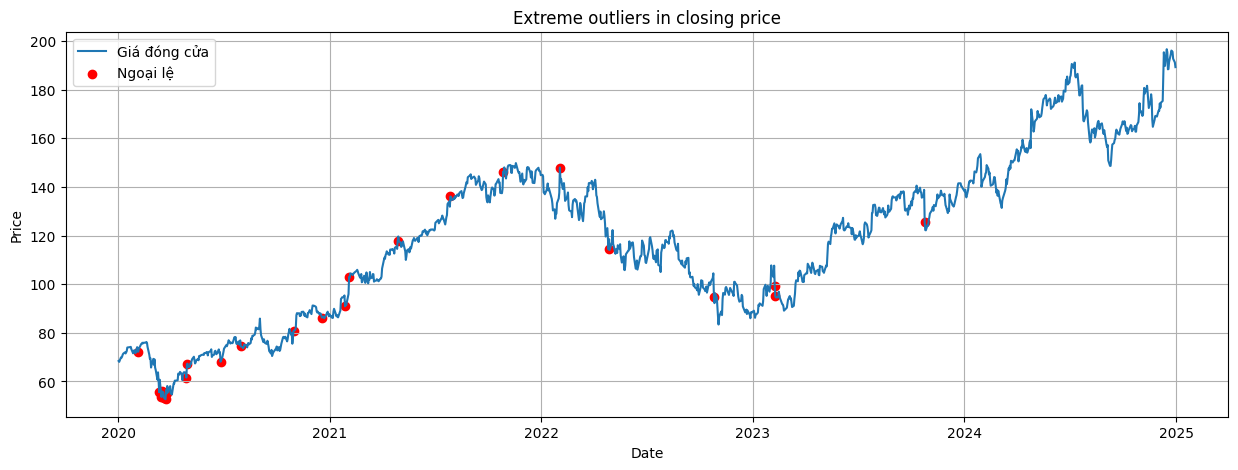

In [10]:
# Visualize extreme outliers
plt.figure(figsize=(15, 5))
plt.plot(google['Date'], google['Close'], label='Giá đóng cửa')
plt.scatter(extreme_outliers['Date'], extreme_outliers['Close'], color='red', label='Ngoại lệ')
plt.title('Extreme outliers in closing price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

Text(0.5, 0, 'Volume')

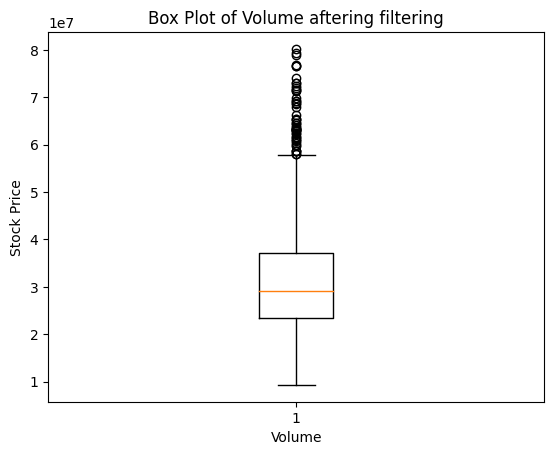

In [11]:
# Removing extreme outliers
google = google[google["Volume"] <= (upper_bound + 1.5 * IQR)]

# Visualize distribution of Volume aftering filtering
plt.boxplot(x=google['Volume'])
plt.title("Box Plot of Volume aftering filtering")
plt.ylabel("Stock Price")
plt.xlabel('Volume')

### Financial Analysis

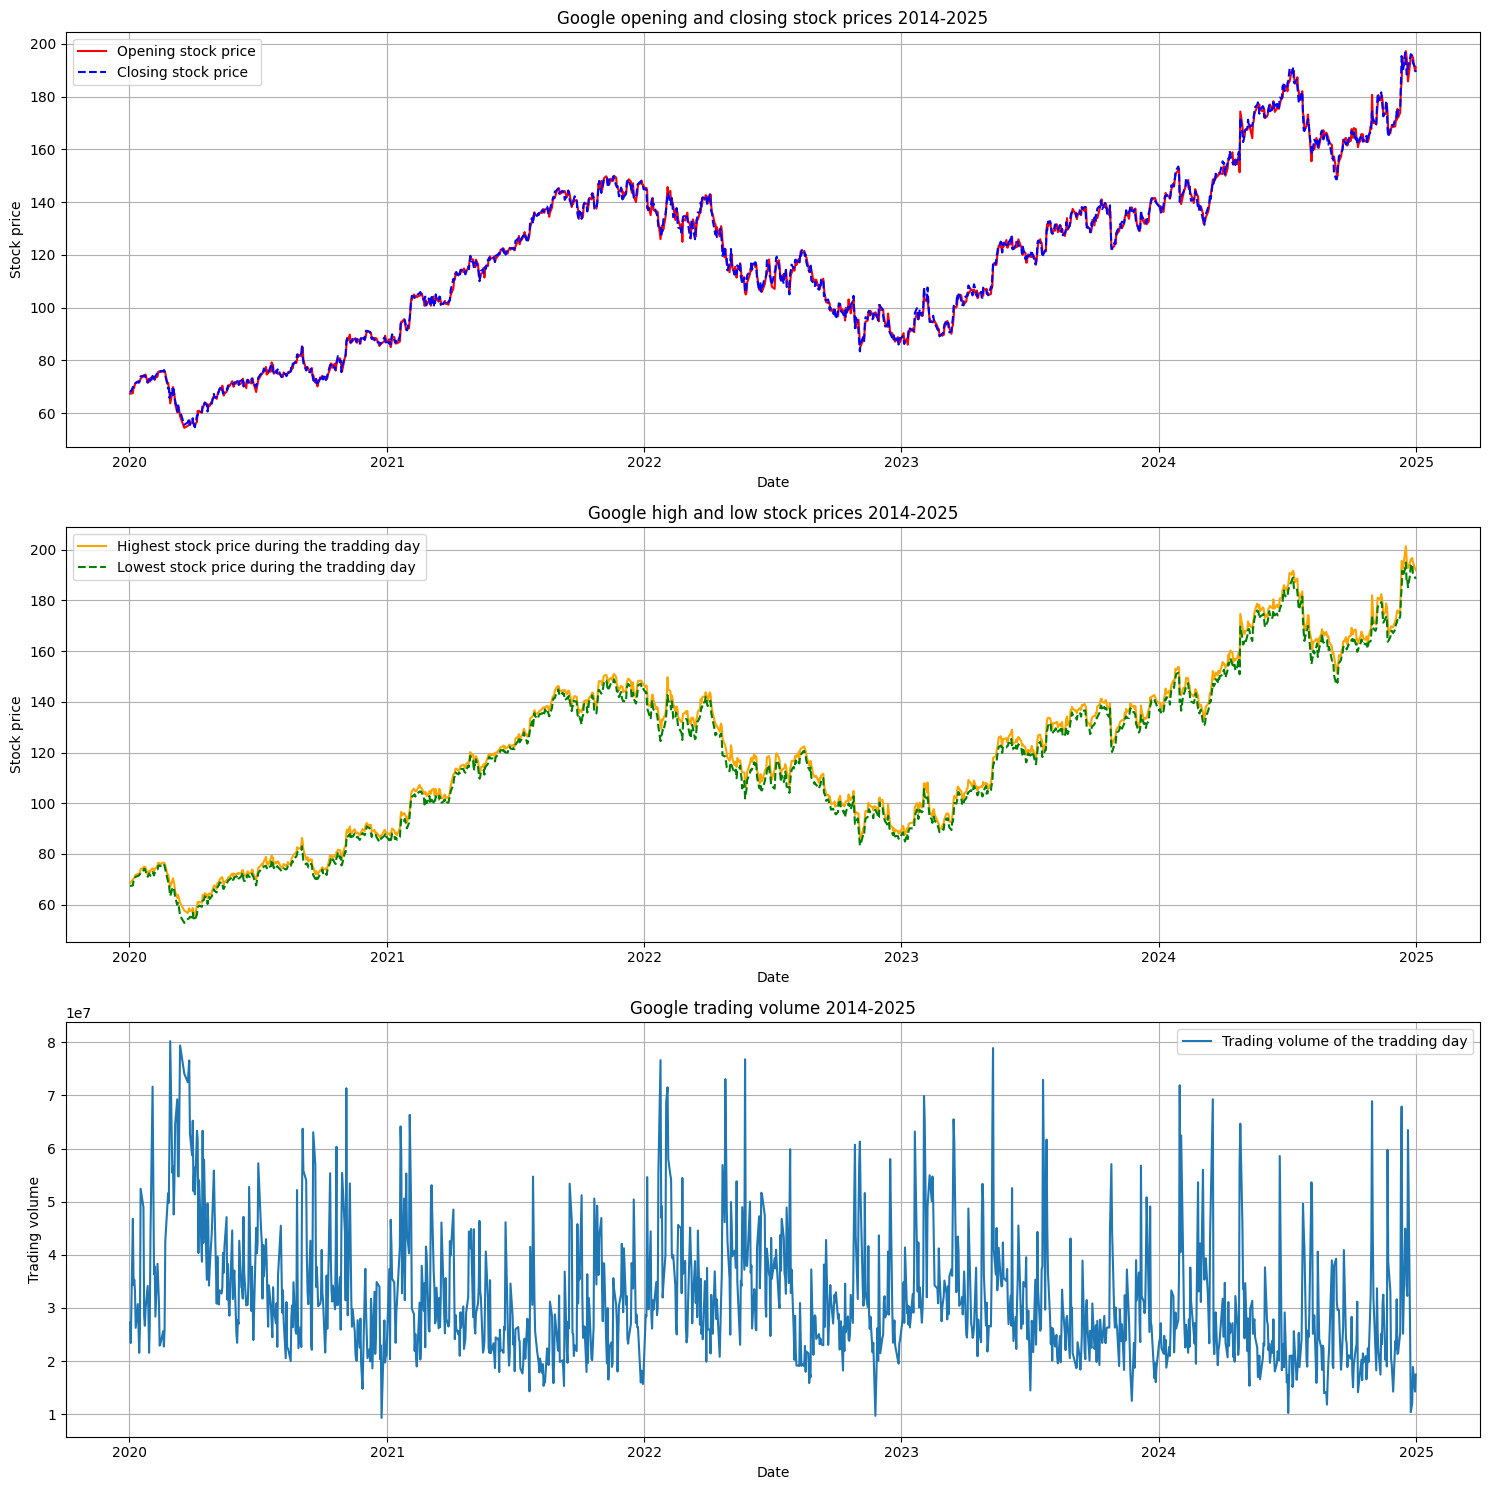

In [12]:
# Visualize Google stock price 2014 - 2025
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

# Opening and Close price
axs[0].plot(google['Date'], google['Open'], color='r', label ='Opening stock price')
axs[0].plot(google['Date'], google['Close'], color='b', linestyle="dashed", label ='Closing stock price')
axs[0].set_title('Google opening and closing stock prices 2014-2025')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Stock price')
axs[0].legend()
axs[0].grid()

# High and Low price
axs[1].plot(google['Date'], google['High'], color='orange', label ='Highest stock price during the tradding day')
axs[1].plot(google['Date'], google['Low'], color='g', linestyle="dashed", label ='Lowest stock price during the tradding day')
axs[1].set_title('Google high and low stock prices 2014-2025')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Stock price')
axs[1].legend()
axs[1].grid()

# Trading Volume
axs[2].plot(google['Date'], google['Volume'], label ='Trading volume of the tradding day')
axs[2].set_title('Google trading volume 2014-2025')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Trading volume')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()

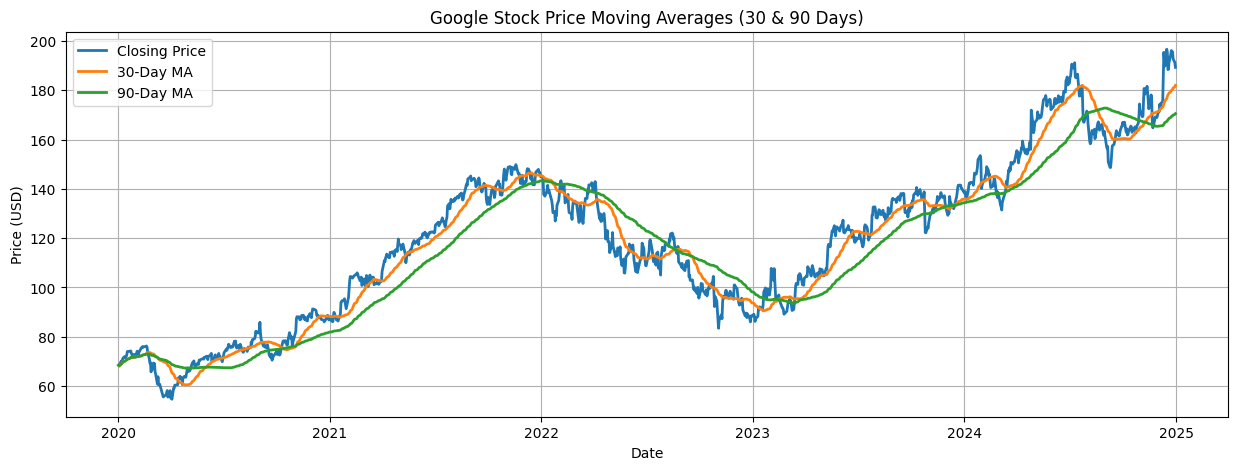

In [13]:
# Moving averages (Đường trung bình động - Đường nối tất cả mức giá đóng cửa trung bình)
google.loc[:, "Close_MA30"] = google["Close"].rolling(window=30, min_periods=1).mean()    # 30 ngày
google.loc[:, "Close_MA90"] = google["Close"].rolling(window=90, min_periods=1).mean()   # 90 ngày

plt.figure(figsize=(15, 5))
sns.lineplot(x=google['Date'], y=google["Close"], label="Closing Price", linewidth=2)
sns.lineplot(x=google['Date'], y=google["Close_MA30"], label="30-Day MA", linewidth=2)
sns.lineplot(x=google['Date'], y=google["Close_MA90"], label="90-Day MA", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Google Stock Price Moving Averages (30 & 90 Days)")
plt.legend()
plt.grid()
plt.show()

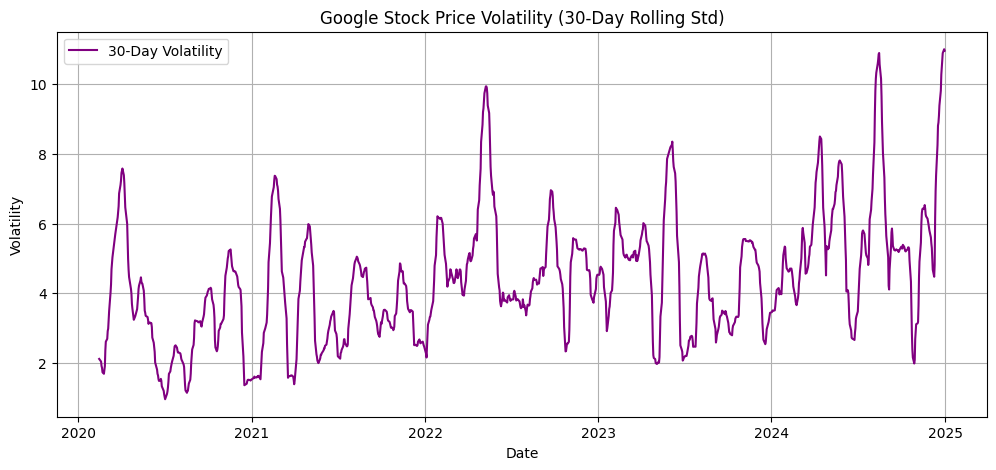

In [14]:
# Volatility (Độ biến Động - Độ lệch chuẩn của giá đóng cửa trong 30 ngày)
google["Volatility_30"] = google["Close"].rolling(window=30).std()  # 30 ngày

plt.figure(figsize=(12, 5))
plt.plot(google['Date'], google["Volatility_30"], label="30-Day Volatility", color='purple')
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Google Stock Price Volatility (30-Day Rolling Std)")
plt.legend()
plt.grid()
plt.show()

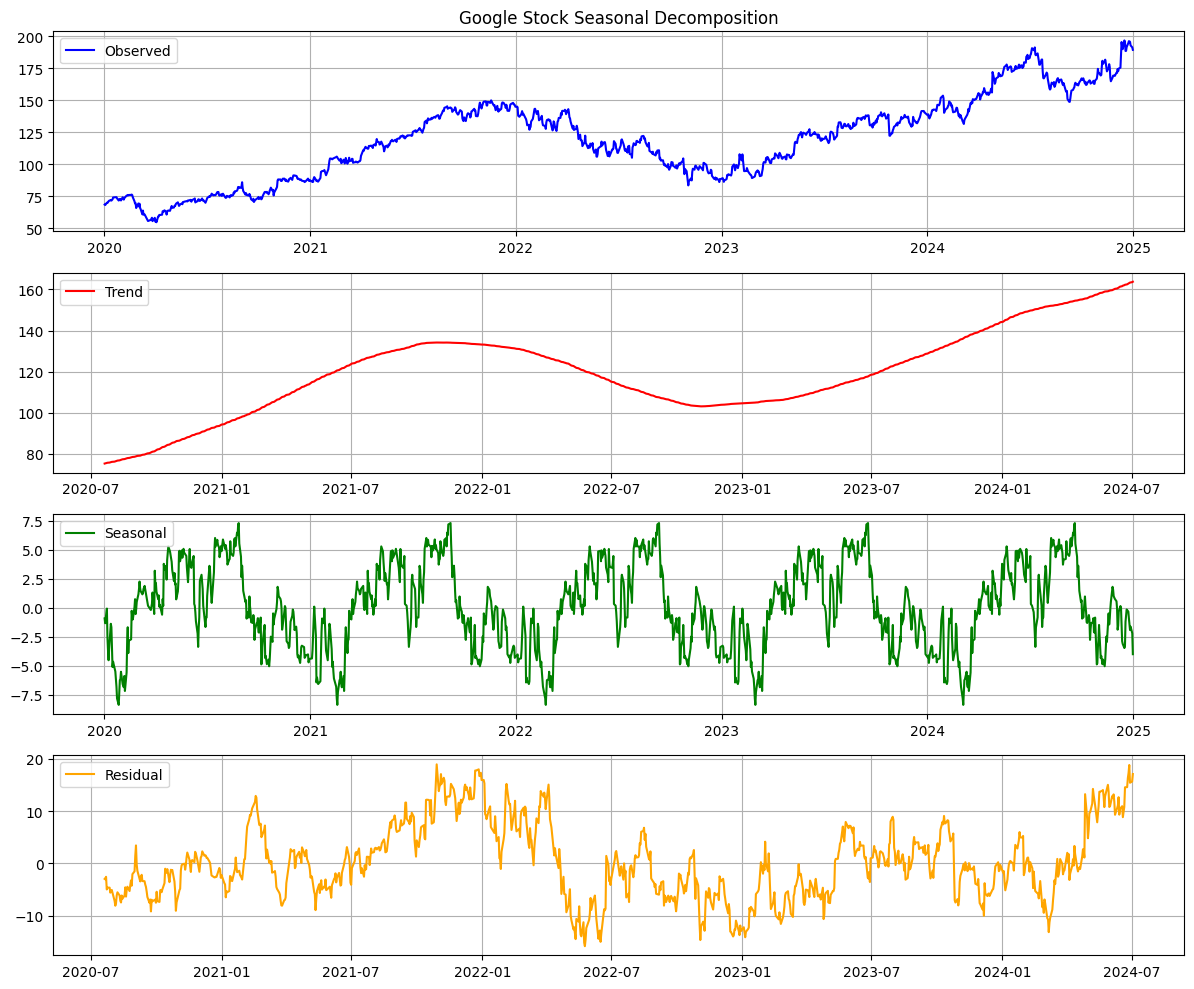

In [15]:
# Seasonal Decomposition (Phân tích tính thời vụ trên giá đóng cửa)
decomposition = seasonal_decompose(google["Close"], model="additive", period=252)   # 252 ngày giao dịch/năm

plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.title("Google Stock Seasonal Decomposition")
plt.plot(google['Date'], decomposition.observed, label="Observed", color="blue")    # Observed (Dữ liệu gốc): Giá đóng cửa theo thời gian
plt.grid()
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(google['Date'], decomposition.trend, label="Trend", color="red")           # Trend (Xu hướng): Xu hướng dài hạn của giá cổ phiếu
plt.grid()
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(google['Date'], decomposition.seasonal, label="Seasonal", color="green")   # Seasonal (Thời vụ): Biến động có tính chu kỳ hàng năm
plt.grid()
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(google['Date'], decomposition.resid, label="Residual", color="orange")     # Residual (Phần dư): Phần không giải thích được bởi xu hướng và thời vụ
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

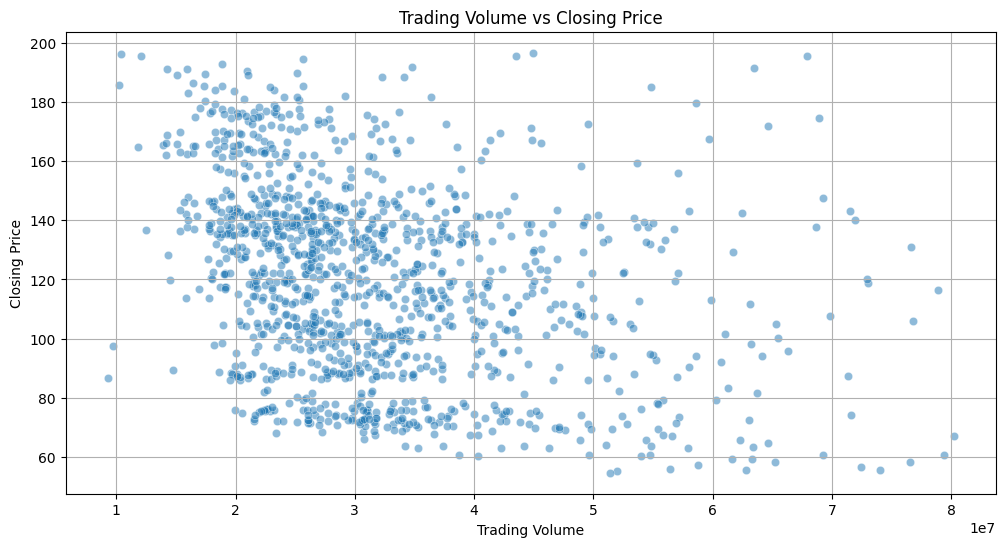

In [16]:
# Volume vs. Closing Price Scatter Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x=google["Volume"], y=google["Close"], alpha=0.5)
plt.xlabel("Trading Volume")
plt.ylabel("Closing Price")
plt.title("Trading Volume vs Closing Price")
plt.grid()
plt.show()

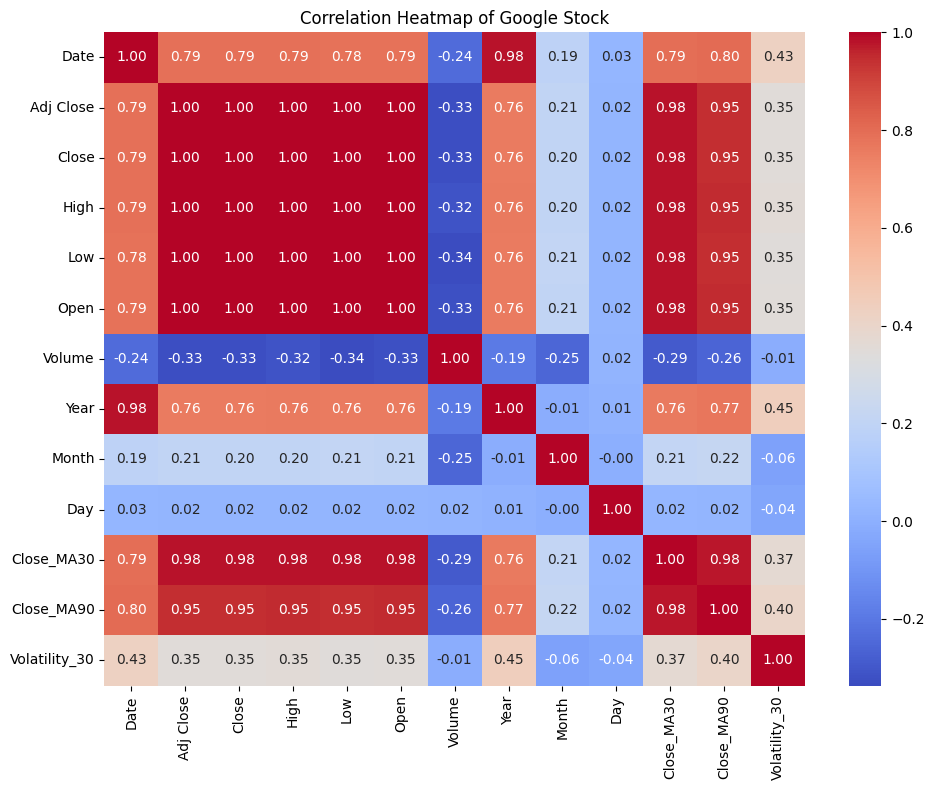

In [17]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = google.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Google Stock')
plt.tight_layout()
plt.show()

In [ ]:
# Save the proccessed data
google.to_csv("Google_Stock_2020_2025.csv")

# Time Series Forcasting

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap

# Split data into train (80%) and test (20%)
train_size = int(len(google) * 0.8)
train, test = google[:train_size]['Close'], google[train_size:]['Close']
train_date, test_date = google[:train_size]['Date'], google[train_size:]['Date']  # Split the date for visualization

print(train.shape)
print(test.shape)

(986,)
(247,)


## ARIMA


In [19]:
from statsmodels.tsa.arima.model import ARIMA

# Define ARIMA model
arima = ARIMA(train, order=(1, 1, 1))
# Train model
arima_model = arima.fit()

c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


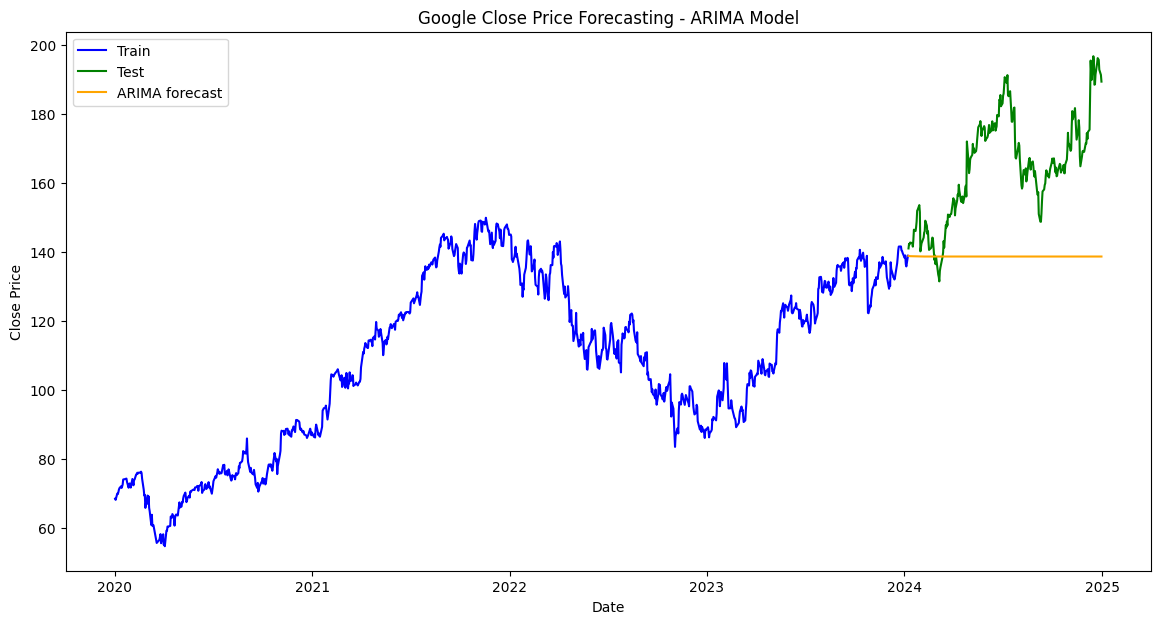

In [20]:
# Forecast
arima_forecast = arima_model.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train_date, train, label='Train', color='blue')
plt.plot(test_date, test, label='Test', color='green')
plt.plot(test_date, arima_forecast, label='ARIMA forecast', color='orange')
plt.title('Google Close Price Forecasting - ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

## Evaluation

In [21]:
rmse_arima = np.sqrt(mean_squared_error(test, arima_forecast))
mae_arima = mean_absolute_error(test, arima_forecast)
print(f"ARIMA - RMSE: {rmse_arima:.2f}, MAE: {mae_arima:.2f}")

ARIMA - RMSE: 29.81, MAE: 25.99


## XAI with ARIMA

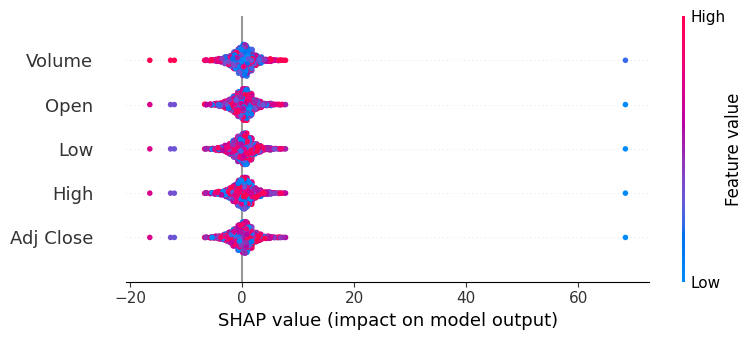

Counterfactual Example:
Date             2024-01-24 00:00:00
Adj Close                 148.162903
Close                     145.556304
High                      149.850006
Low                       148.100006
Open                      148.539993
Volume                      25233500
Year                            2024
Month                              1
Day                               24
Close_MA30                   139.633
Close_MA90                135.665889
Volatility_30               4.492738
Name: 1021, dtype: object


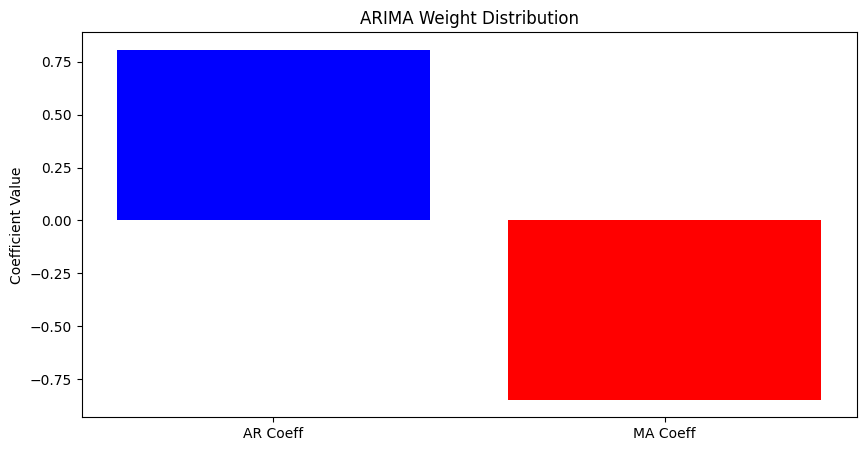

In [22]:
# SHAP Analysis
residuals = arima_model.resid
shap_values = shap.Explanation(
    values=np.tile(residuals.values.reshape(-1, 1), (1, 5)),  # Expand residuals across 5 features
    base_values=np.tile(residuals.mean(), (1, 5)),  # Expand mean across 5 features
    data=google.iloc[:len(residuals)][['Adj Close', 'High', 'Low', 'Open', 'Volume']]
)
shap.summary_plot(
    shap_values.values, 
    features=google.iloc[:len(residuals)][['Adj Close', 'High', 'Low', 'Open', 'Volume']], 
    feature_names=['Adj Close', 'High', 'Low', 'Open', 'Volume']
)

# Specify a test sample
sample_index = 10  # Selecting the 10th sample from the test set

# ICFTS - Counterfactual Explanation
def generate_counterfactual(instance, target):
    modified_instance = instance.copy()
    modified_instance['Close'] = target  # Adjust Close price to desired counterfactual value
    return modified_instance

cf_example = generate_counterfactual(google.iloc[train_size + sample_index], target=arima_forecast.iloc[sample_index] * 1.05)
print("Counterfactual Example:")
print(cf_example)

# DAVOTS - Visualization of Weight Distribution
plt.figure(figsize=(10, 5))
plt.bar(['AR Coeff', 'MA Coeff'], [arima_model.arparams[0], arima_model.maparams[0]], color=['blue', 'red'])
plt.title('ARIMA Weight Distribution')
plt.ylabel('Coefficient Value')
plt.show()


## SARIMA

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA model
sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
# Train model
sarima_model = sarima.fit()

c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


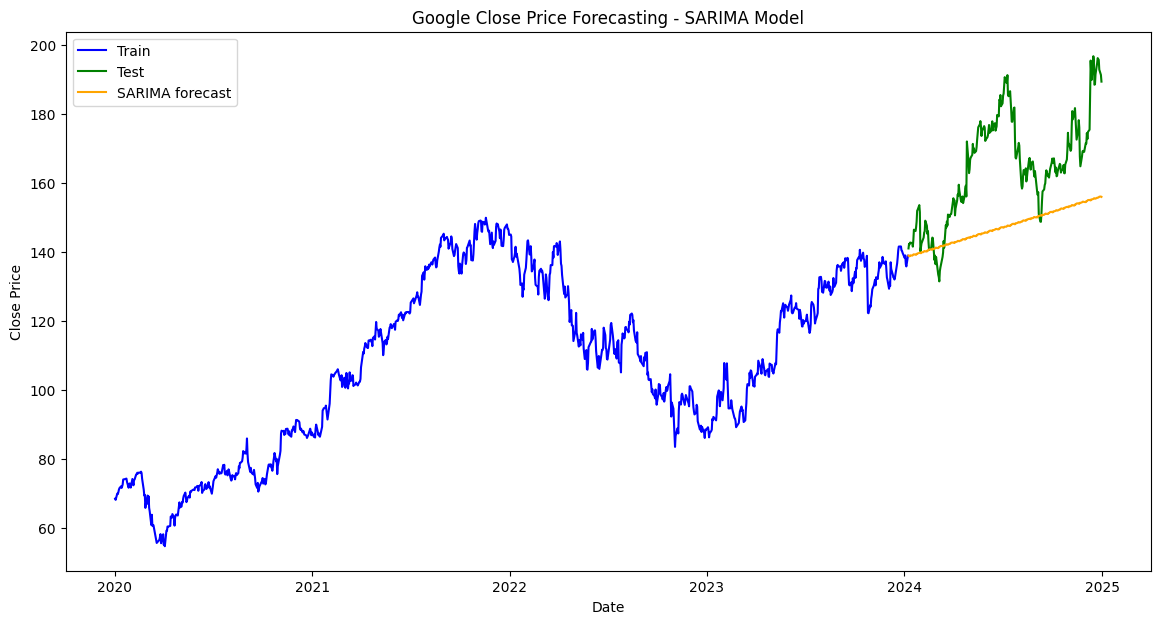

In [24]:
# Forecast
sarima_forecast = sarima_model.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train_date, train, label='Train', color='blue')
plt.plot(test_date, test, label='Test', color='green')
plt.plot(test_date, sarima_forecast, label='SARIMA forecast', color='orange')
plt.title('Google Close Price Forecasting - SARIMA Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

## Evaluation

In [25]:
rmse_sarima = np.sqrt(mean_squared_error(test, sarima_forecast))
mae_sarima = mean_absolute_error(test, sarima_forecast)
print(f"SARIMA - RMSE: {rmse_sarima:.2f}, MAE: {mae_sarima:.2f}")

SARIMA - RMSE: 20.97, MAE: 17.61


## XAI with SARIMA

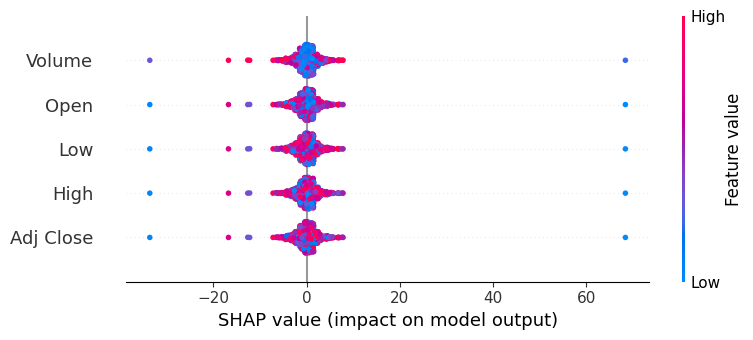

Counterfactual Example:
Date             2024-01-24 00:00:00
Adj Close                 148.162903
Close                     146.352339
High                      149.850006
Low                       148.100006
Open                      148.539993
Volume                      25233500
Year                            2024
Month                              1
Day                               24
Close_MA30                   139.633
Close_MA90                135.665889
Volatility_30               4.492738
Name: 1021, dtype: object


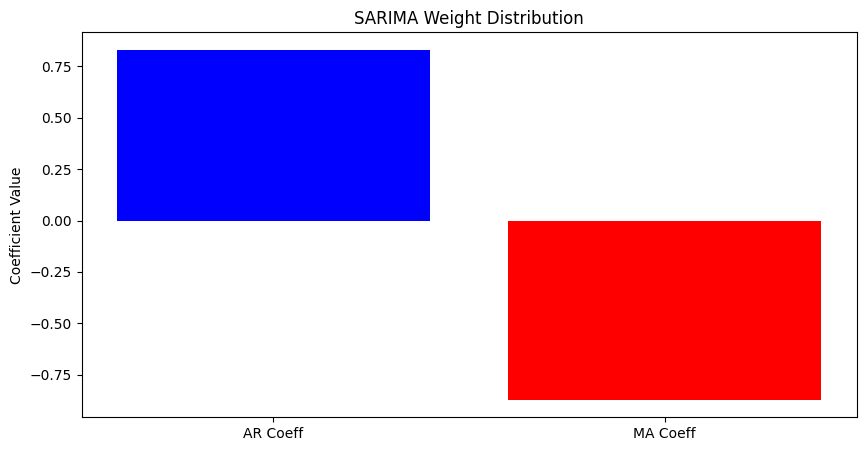

In [26]:
# SHAP Analysis on Sarinma Model
residuals = sarima_model.resid
shap_values = shap.Explanation(
    values=np.tile(residuals.values.reshape(-1, 1), (1, 5)),  # Expand residuals across 5 features
    base_values=np.tile(residuals.mean(), (1, 5)),  # Expand mean across 5 features
    data=google.iloc[:len(residuals)][['Adj Close', 'High', 'Low', 'Open', 'Volume']]
)
shap.summary_plot(
    shap_values.values, 
    features=google.iloc[:len(residuals)][['Adj Close', 'High', 'Low', 'Open', 'Volume']], 
    feature_names=['Adj Close', 'High', 'Low', 'Open', 'Volume']
)
# ICFTS - Counterfactual Explanation
def generate_counterfactual(instance, target):
    modified_instance = instance.copy()
    modified_instance['Close'] = target  # Adjust Close price to desired counterfactual value
    return modified_instance

cf_example = generate_counterfactual(google.iloc[train_size + sample_index], target=sarima_forecast.iloc[sample_index] * 1.05)
print("Counterfactual Example:")
print(cf_example)

# DAVOTS - Visualization of Weight Distribution
plt.figure(figsize=(10, 5))
plt.bar(['AR Coeff', 'MA Coeff'], [sarima_model.arparams[0], sarima_model.maparams[0]], color=['blue', 'red'])
plt.title('SARIMA Weight Distribution')
plt.ylabel('Coefficient Value')
plt.show()



## LSTM

In [27]:
from sklearn.preprocessing import MinMaxScaler

# Select Close price for forecasting
data = google[['Close']].values

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Function to create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])  # Take window_size previous values
        y.append(data[i, 0])  # Predict the next value
    return np.array(X), np.array(y)

# Define window size (e.g., 60 days)
window_size = 60
X, y = create_sequences(scaled_data, window_size)

# Split data into train (80%) and test (20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(938, 60, 1) (235, 60, 1)
(938,) (235,)


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D

# Build LSTM model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
# Compile model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
# Train model
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20


c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0416 - val_loss: 0.0013
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0043 - val_loss: 0.0011
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0022 - val_l

In [29]:
# Forecast
y_pred_lstm = model_lstm.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


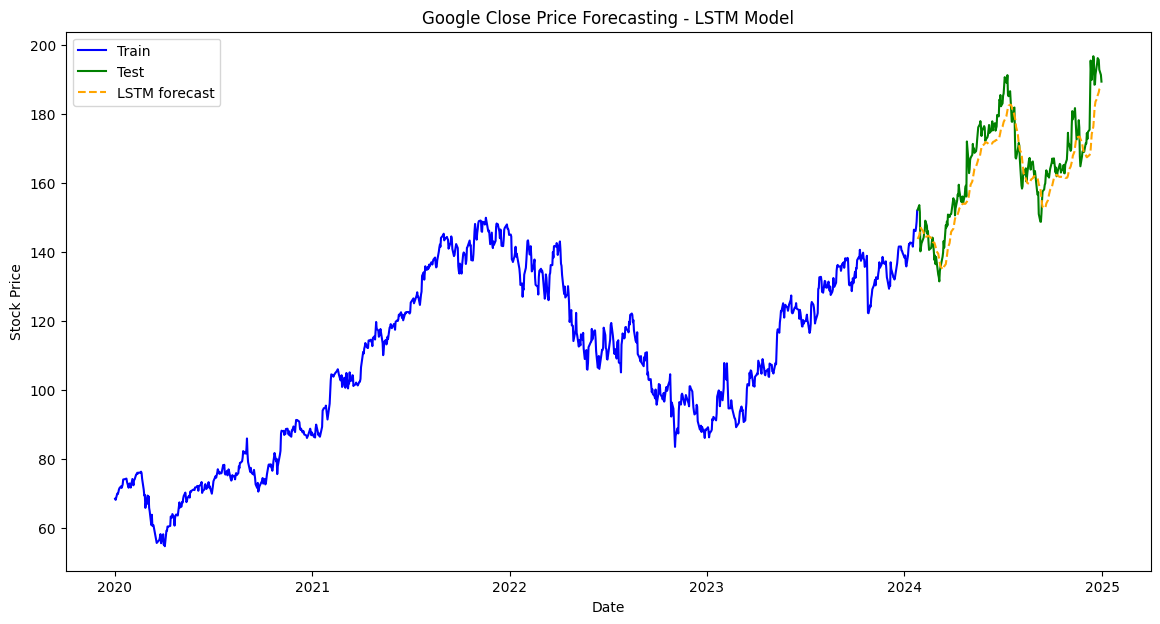

In [30]:
# Prepare full-scale actual data
actual_prices = scaler.inverse_transform(scaled_data)  # Full dataset in original scale
train_actual = actual_prices[:train_size + window_size]  # Train data (including window offset)
test_actual = actual_prices[train_size + window_size:]  # Test data

# Inverse transform predictions to original scale
y_pred_rescaled_lstm = scaler.inverse_transform(y_pred_lstm)

# Plot actual vs predicted values
plt.figure(figsize=(14,7))
plt.plot(google['Date'][:train_size + window_size], train_actual, label="Train", color='blue')
plt.plot(google['Date'][train_size+window_size:], test_actual, label="Test", color='green')
plt.plot(google['Date'][train_size+window_size:], y_pred_rescaled_lstm, label="LSTM forecast", color='orange', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Google Close Price Forecasting - LSTM Model")
plt.legend()
plt.show()

## Evaluation

In [31]:
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse_lstm = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled_lstm))
mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_rescaled_lstm)
print(f"LSTM - RMSE: {rmse_lstm:.2f}, MAE: {mae_lstm:.2f}")

LSTM - RMSE: 6.74, MAE: 5.50


## XAI with LSTM

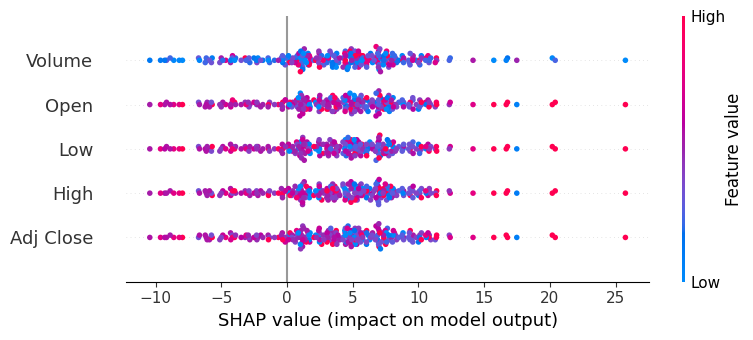

Counterfactual Example:
Date             2023-11-13 00:00:00
Adj Close                 131.612885
Close                      151.52766
High                      132.589996
Low                           131.25
Open                      131.779999
Volume                      18324800
Year                            2023
Month                             11
Day                               13
Close_MA30                133.243334
Close_MA90                130.948111
Volatility_30               5.489642
Name: 973, dtype: object


In [32]:
# Calculate residuals for LSTM model
residuals = y_test_rescaled.flatten() - y_pred_rescaled_lstm.flatten()

# SHAP Analysis on LSTM Model
shap_values = shap.Explanation(
    values=np.tile(residuals.reshape(-1, 1), (1, 5)),  # Expand residuals across 5 features
    base_values=np.tile(residuals.mean(), (1, 5)),  # Expand mean across 5 features
    data=google.iloc[:len(residuals)][['Adj Close', 'High', 'Low', 'Open', 'Volume']]
)
shap.summary_plot(
    shap_values.values, 
    features=google.iloc[:len(residuals)][['Adj Close', 'High', 'Low', 'Open', 'Volume']], 
    feature_names=['Adj Close', 'High', 'Low', 'Open', 'Volume']
)

# ICFTS - Counterfactual Explanation
def generate_counterfactual(instance, target):
    modified_instance = instance.copy()
    modified_instance['Close'] = target  # Adjust Close price to desired counterfactual value
    return modified_instance

cf_example = generate_counterfactual(google.iloc[train_size + sample_index], target=y_pred_rescaled_lstm[sample_index][0] * 1.05)
print("Counterfactual Example:")
print(cf_example)

# DAVOTS - Visualization of Weight Distribution
# LSTM does not have AR or MA coefficients, so this part is not applicable.

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


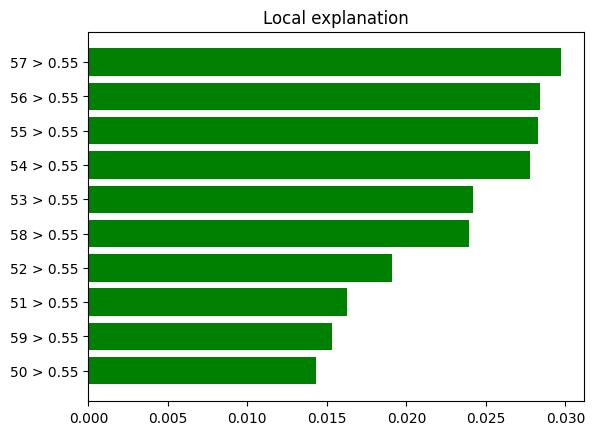

In [33]:
# Ensure training data is extracted correctly
X_train_flat = X_train.reshape((X_train.shape[0], -1))

# Define a prediction function for LIME
def lstm_predict(X):
    X_reshaped = X.reshape((X.shape[0], window_size, 1))
    return model_lstm.predict(X_reshaped)

# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_flat, mode="regression")

# Select a sample instance from the test set
sample_instance = X_test[sample_index].reshape(-1)

# Explain the prediction for the sample instance
exp = explainer.explain_instance(sample_instance, lstm_predict)

# Display the explanation
exp.as_pyplot_figure()
plt.show()

## Transformer

In [34]:
import tensorflow as tf

# Build Transformer model
class TimeSeriesTransformer(tf.keras.Model):
    def __init__(self, input_shape):
        super().__init__()
        self.attn = MultiHeadAttention(num_heads=2, key_dim=32)
        self.norm = LayerNormalization()
        self.dropout = Dropout(0.1)
        self.pool = GlobalAveragePooling1D()
        self.fc = Dense(1)

    def call(self, x):
        attn_output = self.attn(x, x)
        x = self.norm(x + attn_output)
        x = self.dropout(x)
        x = self.pool(x)
        return self.fc(x)

# Compile model
model_tf = TimeSeriesTransformer(X_train.shape[1:])
model_tf.compile(optimizer='adam', loss='mean_squared_error')
# Train model
model_tf.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1580 - val_loss: 0.2655
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1204 - val_loss: 0.2104
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0941 - val_loss: 0.1649
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0692 - val_loss: 0.1284
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0538 - val_loss: 0.1000
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0382 - val_loss: 0.0795
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0335 - val_loss: 0.0643
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0292 - val_loss: 0.0541
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0279 - val_loss: 0.0468
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0260 - val_loss: 0.0426
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0266 - val_loss: 0.0406
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0275 - val_l

In [35]:
# Forecast
y_pred_tf = model_tf.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


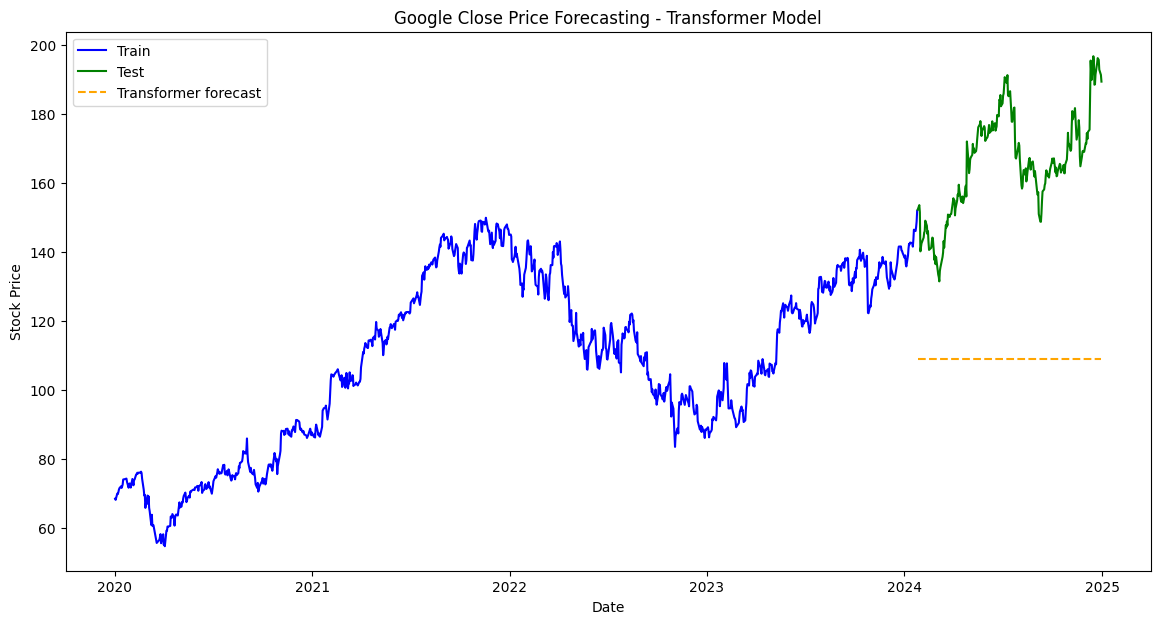

In [36]:
# Prepare full-scale actual data
actual_prices = scaler.inverse_transform(scaled_data)  # Full dataset in original scale
train_actual = actual_prices[:train_size + window_size]  # Train data (including window offset)
test_actual = actual_prices[train_size + window_size:]  # Test data

# Inverse transform predictions to original scale
y_pred_rescaled_tf = scaler.inverse_transform(y_pred_tf)

# Visualiza the result
plt.figure(figsize=(14,7))
plt.plot(google['Date'][:train_size + window_size], train_actual, label="Train", color='blue')
plt.plot(google['Date'][train_size+window_size:], test_actual, label="Test", color='green')
plt.plot(google['Date'][train_size+window_size:], y_pred_rescaled_tf, label="Transformer forecast", color='orange', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Google Close Price Forecasting - Transformer Model")
plt.legend()
plt.show()


## Evaluation

In [37]:
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse_tf = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled_tf))
mae_tf = mean_absolute_error(y_test_rescaled, y_pred_rescaled_tf)
print(f"Transformer - RMSE: {rmse_tf:.2f}, MAE: {mae_tf:.2f}")

Transformer - RMSE: 58.39, MAE: 56.51


## XAI with Transformer

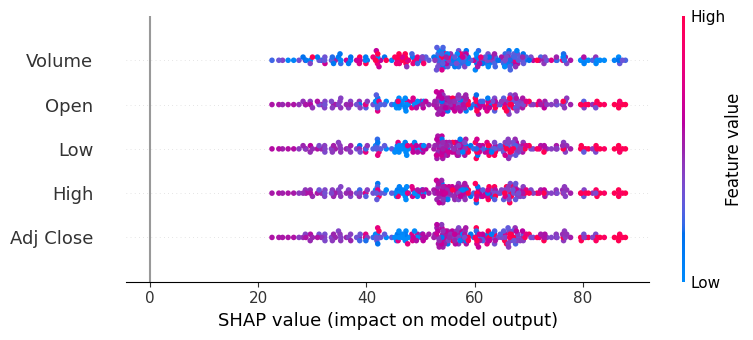

Counterfactual Example:
Date             2023-11-13 00:00:00
Adj Close                 131.612885
Close                     114.282253
High                      132.589996
Low                           131.25
Open                      131.779999
Volume                      18324800
Year                            2023
Month                             11
Day                               13
Close_MA30                133.243334
Close_MA90                130.948111
Volatility_30               5.489642
Name: 973, dtype: object


In [38]:
# Calculate residuals for Transfomer model
residuals = y_test_rescaled.flatten() - y_pred_rescaled_tf.flatten()

# SHAP Analysis on Transfomer model
shap_values = shap.Explanation(
    values=np.tile(residuals.reshape(-1, 1), (1, 5)),  # Expand residuals across 5 features
    base_values=np.tile(residuals.mean(), (1, 5)),  # Expand mean across 5 features
    data=google.iloc[:len(residuals)][['Adj Close', 'High', 'Low', 'Open', 'Volume']]
)
shap.summary_plot(
    shap_values.values, 
    features=google.iloc[:len(residuals)][['Adj Close', 'High', 'Low', 'Open', 'Volume']], 
    feature_names=['Adj Close', 'High', 'Low', 'Open', 'Volume']
)

# ICFTS - Counterfactual Explanation
def generate_counterfactual(instance, target):
    modified_instance = instance.copy()
    modified_instance['Close'] = target  # Adjust Close price to desired counterfactual value
    return modified_instance

cf_example = generate_counterfactual(google.iloc[train_size + sample_index], target=y_pred_rescaled_tf[sample_index][0] * 1.05)
print("Counterfactual Example:")
print(cf_example)

# DAVOTS - Visualization of Weight Distribution
# Transformer does not have AR or MA coefficients, so this part is not applicable.

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


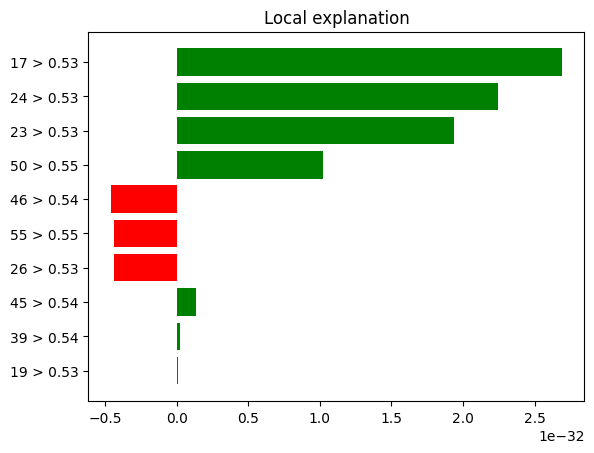

In [39]:
# Ensure training data is extracted correctly
X_train_flat = X_train.reshape((X_train.shape[0], -1))

# Define a prediction function for LIME
def transformer_predict(X):
    X_reshaped = X.reshape((X.shape[0], window_size, 1))
    return model_tf.predict(X_reshaped)

# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_flat, mode="regression")

# Select a sample instance from the test set
sample_instance = X_test[sample_index].reshape(-1)

# Explain the prediction for the sample instance
exp = explainer.explain_instance(sample_instance, transformer_predict)

# Display the explanation
exp.as_pyplot_figure()
plt.show()

# Model Comparison

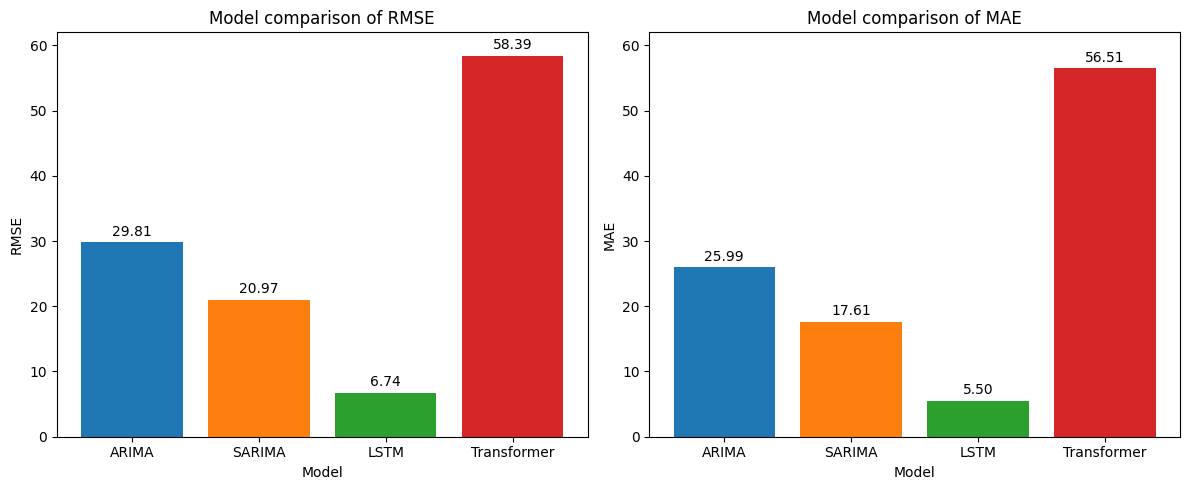

In [41]:
models = {
    "ARIMA": [rmse_arima, mae_arima],
    "SARIMA": [rmse_sarima, mae_sarima],
    "LSTM": [rmse_lstm, mae_lstm],
    "Transformer": [rmse_tf, mae_tf]
}

# RMSE Comparison
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for i, (model, score) in enumerate(models.items()):
    bar = plt.bar(model, score[0])
    plt.text(i, score[0] + 1, f'{score[0]:.2f}', ha='center')
plt.title('Model comparison of RMSE')
plt.ylim(0, 62)
plt.xlabel('Model')
plt.ylabel('RMSE')

# MAE Comparison
plt.subplot(1,2,2)
for i, (model, score) in enumerate(models.items()):
    bar = plt.bar(model, score[1])
    plt.text(i, score[1] + 1, f'{score[1]:.2f}', ha='center')
plt.title('Model comparison of MAE')
plt.ylim(0, 62)
plt.xlabel('Model')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()

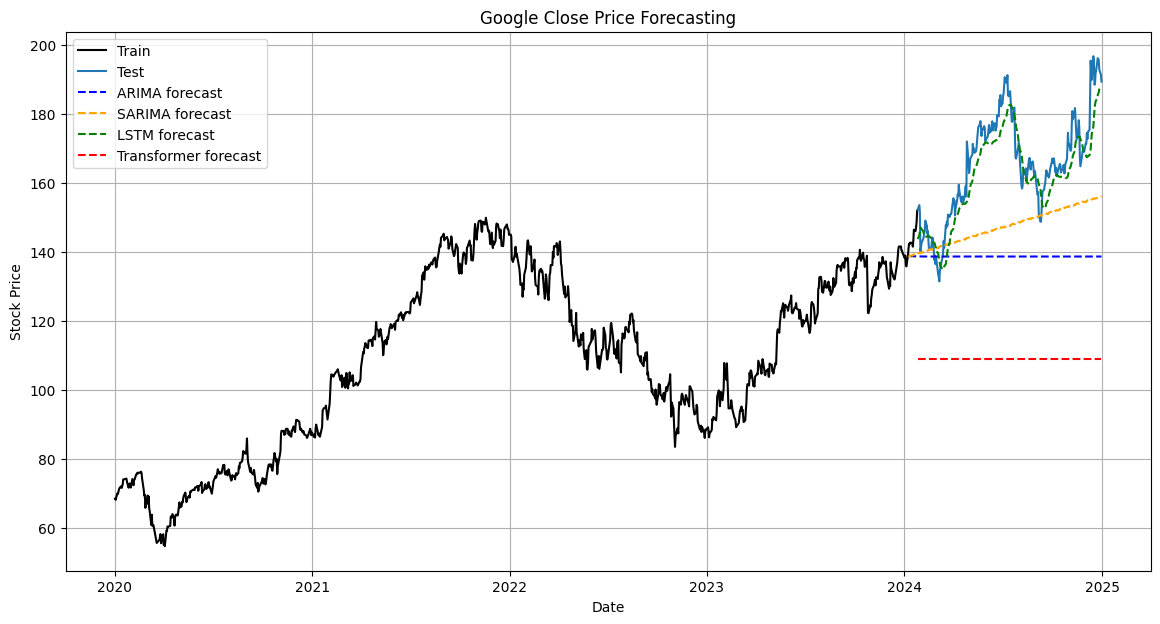

In [42]:
# Visualiza the result
plt.figure(figsize=(14,7))
plt.plot(google['Date'][:train_size + window_size], train_actual, label="Train", color='black')
plt.plot(google['Date'][train_size+window_size:], test_actual, label="Test")
plt.plot(test_date, arima_forecast, label='ARIMA forecast', color='blue', linestyle='dashed')
plt.plot(test_date, sarima_forecast, label='SARIMA forecast', color='orange', linestyle='dashed')
plt.plot(google['Date'][train_size+window_size:], y_pred_rescaled_lstm, label="LSTM forecast", color='green', linestyle='dashed')
plt.plot(google['Date'][train_size+window_size:], y_pred_rescaled_tf, label="Transformer forecast", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Google Close Price Forecasting")
plt.grid()
plt.legend()
plt.show()

In [44]:
import joblib

# save the models
joblib.dump(arima, 'saved_models/arima.pkl')
joblib.dump(sarima, 'saved_models/sarima.pkl')
joblib.dump(model_lstm, 'saved_models/lstm.pkl')
joblib.dump(model_tf, 'saved_models/transformer.pkl')

['saved_models/transformer.pkl']